# Covid-19: From model prediction to model predictive control

## Scenario-analysis with the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Load interaction matrices

In [2]:
# Load interaction matrices
Nc_home = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELhome.txt", dtype='f', delimiter='\t')
Nc_work = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELwork.txt", dtype='f', delimiter='\t')
Nc_schools = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELschools.txt", dtype='f', delimiter='\t')
Nc_transport = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELtransport.txt", dtype='f', delimiter='\t')
Nc_leisure = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELleisure.txt", dtype='f', delimiter='\t')
Nc_others = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELothers.txt", dtype='f', delimiter='\t')
Nc_total = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELtotal.txt", dtype='f', delimiter='\t')
initN = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELagedist_10year.txt", dtype='f', delimiter='\t')

### Initialise model

In [3]:
h = np.array([[0.0001,0.0003,0.012,0.032,0.049,0.102,0.166,0.243,0.273]])
icu = 0.8*np.array([0.05,0.05,0.05,0.05,0.063,0.122,0.274,0.432,0.709])

In [4]:
model = models.SEIRSAgeModel(initN   = initN,         #16x0 numpy array
                                     beta    = 0.0622, # probability of infection when encountering infected person
                                     sigma   = 3.2, # latent period
                                     omega   = 2.0, # pre-symptomatic infectious period
                                     Nc = Nc_total, #must be a numpy array; average number of human-to-human interactions per day
                                     a = 0.43, # probability of an asymptotic (supermild) infection
                                     m = 1-0.43, # probability of a mild infection
                                     h = h, # probability of hospitalisation for a mild infection
                                     c = 1-icu, # probability of hospitalisation in cohort
                                     da = 7, # days of infection when asymptomatic (supermild)
                                     dm = 7, # days of infection when mild
                                     dc = 8,
                                     dICU = 14,
                                     dICUrec = 6,
                                     dhospital = 7.5, # days before reaching the hospital when heavy or critical
                                     #m0 = np.transpose(np.array([0.000094,0.00022,0.00091,0.0018,0.004,0.013,0.046,0.098,0.18])), # mortality in ICU
                                     m0 = np.ones(9)*0.50,
                                     totalTests = 0,
                                     psi_FP = 0, # probability of a false positive
                                     psi_PP = 1, # probability of a correct test
                                     dq = 14, # days in quarantaine                          
                                     initE = np.ones(9), #must be a numpy array
                                     initI = np.zeros(9),
                                     initA = np.zeros(9), 
                                     initM = np.zeros(9),
                                     initC = np.zeros(9),
                                     initCicurec = np.zeros(9),
                                     initICU = np.zeros(9),
                                     initR = np.zeros(9),
                                     initD = np.zeros(9),
                                     initSQ = np.zeros(9),
                                     initEQ = np.zeros(9),
                                     initIQ = np.zeros(9),
                                     initAQ = np.zeros(9),
                                     initMQ = np.zeros(9),
                                     initRQ = np.zeros(9),
                                     monteCarlo = False,
                                     n_samples = 1,
                            )

### Scrape high-level Sciensano data

In [5]:
index,startdate,ICUvect,hospital = sciensano.get_sciensano_data()

### Perform calibration

In [ ]:
data=[np.transpose(ICUvect[:,0:9]),np.transpose(hospital[:,0:9])]
# set optimisation settings
parNames = ['beta','dc','dICU'] # must be a list!
positions = [np.array([6]),np.array([5,6])] # must be a list!
bounds=((10,60),(0.01,0.12),(1,16),(1,16)) # must be a list!
weights = np.array([1,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,setvar=True,maxiter=60,popsize=60)

No constraints given.
New best for swarm at iteration 1: [4.09331650e+01 4.03461806e-02 1.60000000e+01 4.72532472e+00] 378547.33129840967
Best after iteration 1: [4.09331650e+01 4.03461806e-02 1.60000000e+01 4.72532472e+00] 378547.33129840967
Best after iteration 2: [4.09331650e+01 4.03461806e-02 1.60000000e+01 4.72532472e+00] 378547.33129840967
New best for swarm at iteration 3: [41.08474388  0.04153759  9.87075058  4.75223827] 46052.45533640825
Best after iteration 3: [41.08474388  0.04153759  9.87075058  4.75223827] 46052.45533640825
Best after iteration 4: [41.08474388  0.04153759  9.87075058  4.75223827] 46052.45533640825
Best after iteration 5: [41.08474388  0.04153759  9.87075058  4.75223827] 46052.45533640825
Best after iteration 6: [41.08474388  0.04153759  9.87075058  4.75223827] 46052.45533640825
Best after iteration 7: [41.08474388  0.04153759  9.87075058  4.75223827] 46052.45533640825
Best after iteration 8: [41.08474388  0.04153759  9.87075058  4.75223827] 46052.455336408

In [ ]:
# plot result
model.plotFit(index[0:9],data,positions,modelClr=['red','orange'],legendText=('ICU (model)','Hospitalized (model)','ICU (data)','Hospitalized (data)'),titleText='Belgium')

Slight underestimation of hospitalizations, most likely due to the fact that residence times in the hospital differ from the values used in our model. Using the UZ Ghent data to estimate distributions and incorporating this uncertainty will surely fix this in the future.

### Sample from the posterior distribution of beta

For now, the high-level python package `pyMC3` is used to sample from the posterior distribution of $\beta$. However, due to the high level nature of `pyMC3` it is hard to perform an elegant coupling with the BIOMATH covid-19 model. Because the parameter $\beta$ and the excess time $t_e$ are correlated, we fix the $t_e$ estimate obtained from MLE during the sampling procedure to avoid having a bi- or trimodal distributions for $\beta$.

In [18]:
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

In [19]:
n=theano.shared(float(ICUvect[:,0:idx].size))

@as_op(itypes=[tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def couple2COVID19MODEL(beta,n):
    model.beta = beta
    T = n+model.extraTime-1
    model.sim(T)
    out = (model.sumS,model.sumE,model.sumA,model.sumM,model.sumCtot,model.sumMi,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ)
    positions=np.array([5,6])
    for i in range(int(n)):
        som = 0
        for j in positions:
            som = som + np.mean(out[j],axis=1).reshape(np.mean(out[j],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

with pm.Model() as COVID19MODEL:
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=model.beta, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=20)

    mu = couple2COVID19MODEL(beta,n)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=ICUvect[:,0:idx].flatten())

In [20]:
map_estimate = pm.find_MAP(model=COVID19MODEL, method='L-BFGS-B',tol=1e-12)
map_estimate

logp = -31.362: 100%|██████████| 664/664 [00:26<00:00, 25.27it/s]     


{'beta': array(0.04166077),
 'sigma_log__': array(2.48887494),
 'sigma': array(12.04771412)}

In [12]:
with COVID19MODEL:

    # draw 1000 posterior samples
    trace = pm.sample(10000,start=map_estimate,step=pm.Slice(),cores=12)

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [sigma]
>Slice: [dhospital]
>Slice: [beta]
Sampling chain 1, 0 divergences: 100%|██████████| 600/600 [05:10<00:00,  1.93it/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied va

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1530095c4040>,
      dtype=object)

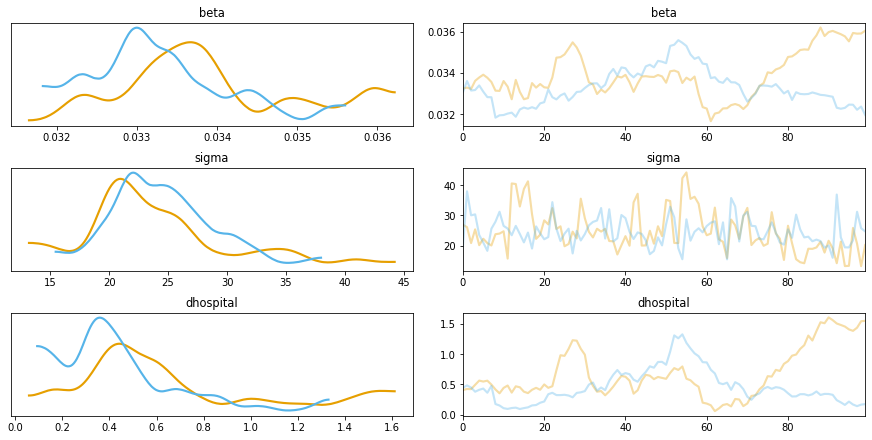

In [14]:
pm.traceplot(trace,varnames=['beta','sigma'])

### Scenarios


Use the code snippet below to see the correspondence between `'t'` in the `pastPolicy` dictionary and the actual date.

In [24]:
# Define data as a list containing data timeseries
data=[np.transpose(ICUvect),np.transpose(hospital)]
# vector with dates
index=pd.date_range(startdate, freq='D', periods=ICUvect.size)
print(index[2],index[50],index[57],index[-1])

2020-03-17 00:00:00 2020-05-04 00:00:00 2020-05-11 00:00:00 2020-05-21 00:00:00


The interaction matrices of the 2008 study by Mossong were gathered under a business-as-usual scenario. It is thus not possible to use the interaction matrices without doing a correction for social distancing. Even when using only the interactions at home (`Nc_home`), the virus cannot be stopped.

In [36]:
sigma1 = 1
sigma2 = 0.1 # rule of four
sigma3 = 0.1 # Arbitrary increase after further relaxing of measures on June 4th

Stringent measures were taken in the evening of March 17th, which corresponds to time-index 3, however, the measures are only 'enforced' on day 8 in the `pastPolicy` dictionary. Why? The change in human behaviour was very gradual, it took between 10-14 days after March 17th before everyone was working at home (see the Google mobility report). In other words, measures were taken on March 17th, but obedience for these measures was gradual, like a ramp. However, in the model we make a step-wise change. The obedience to measures can be adressed in future work.

/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


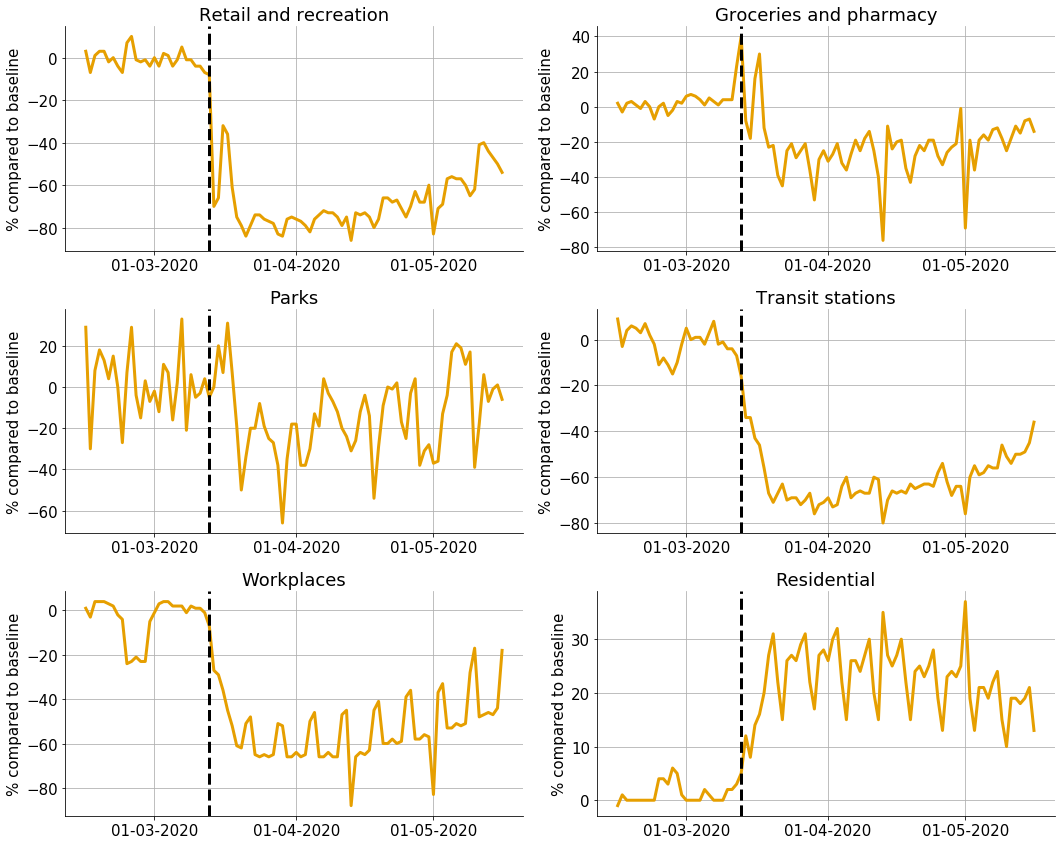

In [33]:
dates,retail_recreation,grocery,parks,transport,work,residential=google.get_google_mobility_data()

Another important issue to adress is the home interaction matrix `Nc_home`. All contacts in these matrices are still assumed to be random, during a lockdown, the interactions at home should somehow be corrected for the 'bubble' effect. Since the average household size in belgium is 2 people, I correct the `Nc_home` matrix with a factor 1/2.

In [49]:
# Create a dictionary of past policies
pastPolicy = {'t':       [7,50,57], 
              'Nc':      [0.3*Nc_home+sigma1*((1-0.70)*Nc_work+(1-0.70)*Nc_transport),
                          # 70 percent reduction in work --> from data gert peersman,
                          # 70 percent reduction in transit --> google community mobility report
                          0.3*Nc_home+sigma2*((1-0.40)*Nc_work+(1-0.50)*Nc_transport),
                          # rule of four: sigma increases
                          # 40 percent reduction in work --> google covid mobility reports
                          # 50 percent reduction in transit --> google covid mobility reports (Contact Koen Schoors for data De Lijn!)
                          0.3*Nc_home+sigma2*((1-0.30)*Nc_work+(1-0.45)*Nc_transport+(1-0.50)*Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          # rule of four
                          # 30 percent reduction in work --> Google
                          # 45 percent reduction in transit --> Google
                          # All ages up untill 12 years back to school --> roughly 50 percent of schools back open
                          # retail & recreation back to 40 percent --> Google mobility report --> assume both leisure and others
                         ]
              }

In [50]:
# Create a dictionary of future policies
futurePolicy = {'t':     [3,18], # May 21th, June 4th 
                'Nc':    [0.3*Nc_home+sigma2*((1-0.20)*Nc_work+(1-0.40)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          # rule of four
                          # 20 percent reduction in work --> If current trend in Google reports persists
                          # 40 percent reduction in transit --> If current trend in Google reports persists
                          # All ages back to school --> a lot of media attention to re-open schools at this point...
                          # retail & recreation still at 40 percent --> Google mobility report --> maybe it's going more up
                          0.5*Nc_home+sigma3*((1-0.20)*Nc_work+(1-0.50)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others)
                          # Phase 3 of lockdown release: will we be able to see more friends? Increase in sigma.
                          # From hereon: scenarios
                         ],
              }

In [51]:
# Run realTimeScenario
model.realTimeScenario(startdate,data,positions,pastPolicy,futurePolicy=futurePolicy,trace=trace['beta'][-50:],T_extra=7,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename='test.svg')

ValueError: Values in `t_eval` are not within `t_span`.

Save your figures by altering the variable `filename = xxxxx.svg`!